In [ ]:
!pip install fastdtw


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512550 sha256=2ee206e340bb86b75fad5c4fbfa02ff572ec67cfba8e69a82fed132a41bb2724
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


Data Visualization and Exploration

Mounted at /content/drive


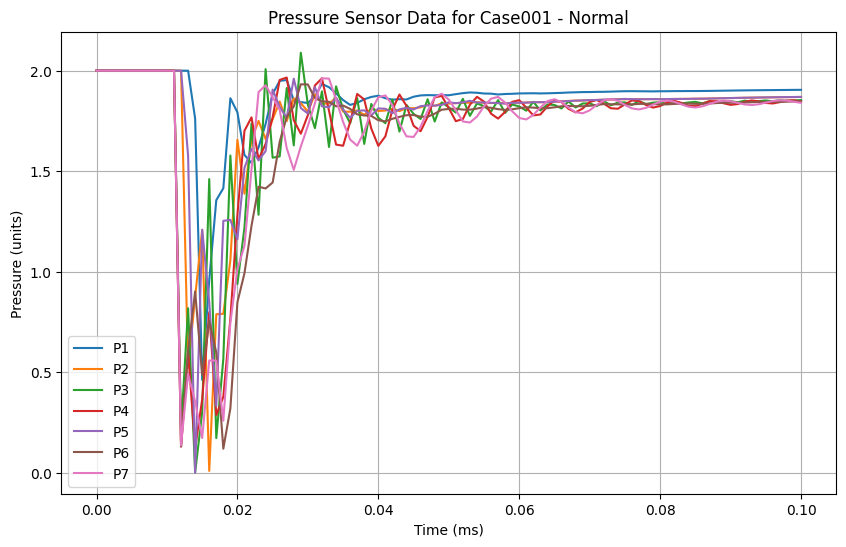

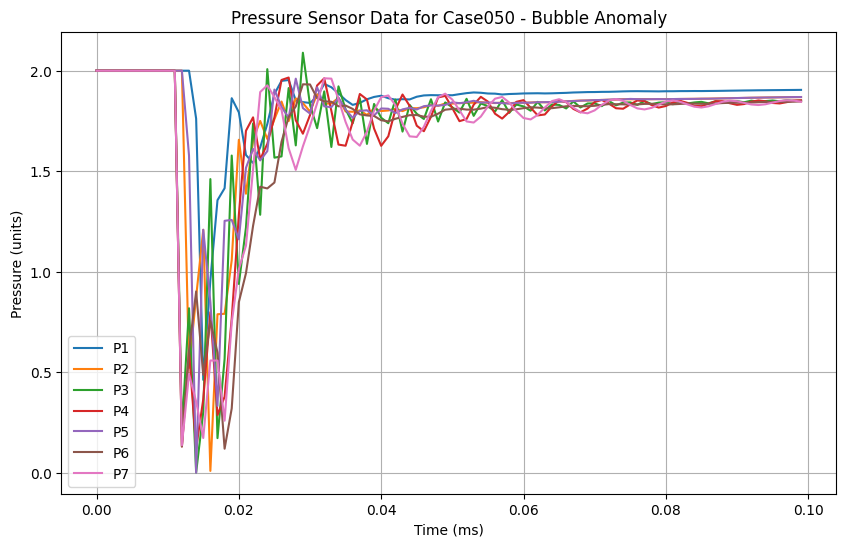

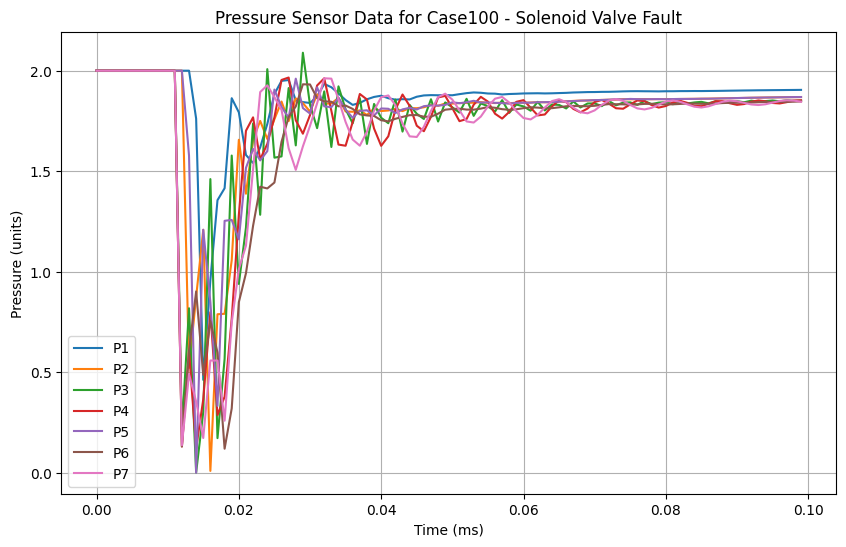

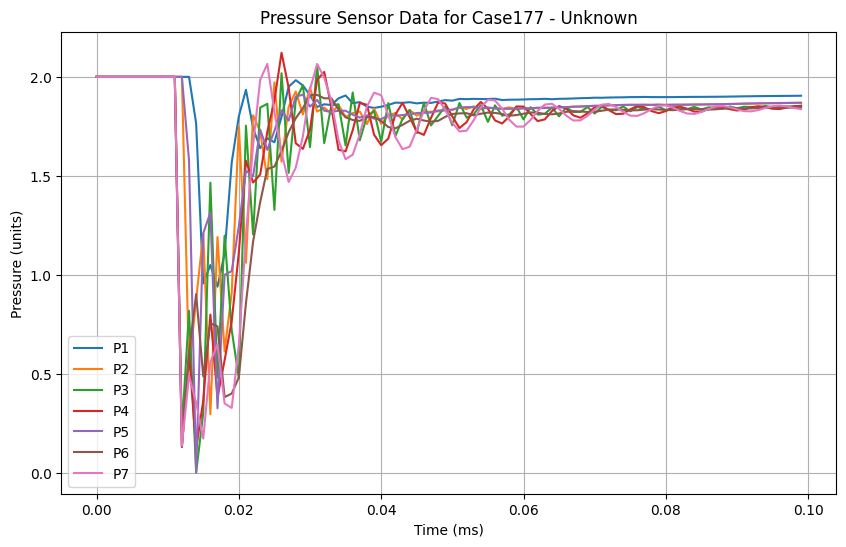

(100, 1)
DTW distance between two time series is: 0.0


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw  # You may need to install this package

# Define the base directory where all files are stored
train_dir = '/content/drive/My Drive/Project 5/Project 5/Dataset/Train/data/'

# List all CSV files in the directory
file_names = [f for f in os.listdir(train_dir) if f.endswith('.csv')]

# Load all files into a list of dataframes
data_frames = []
for file in file_names:
    file_path = os.path.join(train_dir, file)
    df = pd.read_csv(file_path)
    df['Case'] = file.replace('.csv', '')  # Add a column to identify the case
    data_frames.append(df)

# Concatenate all dataframes into one
all_data = pd.concat(data_frames, ignore_index=True)

# Define labels for demonstration purposes
labels = {
    'Case001': 'Normal',
    'Case050': 'Bubble Anomaly',
    'Case100': 'Solenoid Valve Fault',
    'Case177': 'Unknown'
}

# Function to plot pressure sensors
def plot_pressure_sensors(data, title):
    plt.figure(figsize=(10, 6))
    for i in range(1, 8):
        plt.plot(data['TIME'], data[f'P{i}'], label=f'P{i}')
    plt.title(f'Pressure Sensor Data for {title}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Pressure (units)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to extract basic features for DTW comparison
def extract_features(data):
    features = {}
    for i in range(1, 8):  # Assuming sensors P1 to P7
        features[f'P{i}'] = data[f'P{i}'].tolist()  # Store time series data as list for DTW
    return features

# Applying regime separation, feature extraction, and plotting

for case, label in labels.items():
    case_data = all_data[all_data['Case'] == case]
    filtered_data = case_data[case_data['TIME'] <= 0.1]
    features = extract_features(filtered_data)  # Extract features for DTW
    plot_pressure_sensors(filtered_data, f'{case} - {label}')
# Extracting the sensor data
sensor_data_1 = data_frames[0][data_frames[0]['TIME'] <= 0.1]['P1'].values
sensor_data_2 = data_frames[1][data_frames[1]['TIME'] <= 0.1]['P1'].values
sensor_data_1 = sensor_data_1.reshape(-1, 1)
sensor_data_2 = sensor_data_2.reshape(-1, 1)
print(sensor_data_1.shape)
#print(sensor_data_2)
# Applying DTW
distance, path = fastdtw(sensor_data_1, sensor_data_2, dist=euclidean)

print("DTW distance between two time series is:", distance)

Classification for Known and Unkown Status

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import matplotlib.pyplot as plt
import re

# Step 1: Load training and test data
train_dir = '/content/drive/My Drive/Project 5/Project 5/Dataset/Train/data/'
test_dir = '/content/drive/My Drive/Project 5/Project 5/Dataset/Test/data/'
label_path = '/content/drive/My Drive/Project 5/Project 5/Dataset/Train/labels.xlsx'

# Load all training files into a dictionary
train_data = {}
for file in os.listdir(train_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(train_dir, file)
        df = pd.read_csv(file_path)
        train_data[file.replace('.csv', '')] = df

# Load all test files into a dictionary
test_data = {}
for file in os.listdir(test_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(test_dir, file)
        df = pd.read_csv(file_path)
        test_data[file.replace('.csv', '')] = df

# Load labels from Excel
labels_df = pd.read_excel(label_path)
labels_df = labels_df.dropna(subset=['Case#', 'Condition']).copy()
labels_df['Case#'] = labels_df['Case#'].astype(int)
labels_map = dict(zip(labels_df['Case#'], labels_df['Condition']))

# Step 2: Compute thresholds alpha and beta
# Alpha remains fixed at 0.1
alpha = 0.1

# Compute beta based on inter-class distances
inter_class_distances = []
train_keys = list(train_data.keys())

for i, (key1, df1) in enumerate(train_data.items()):
    class1 = labels_map[int(key1.replace('Case', ''))]  # Get class of the first point
    min_distance = float('inf')

    for j, (key2, df2) in enumerate(train_data.items()):
        if i != j:  # Skip comparison with itself
            class2 = labels_map[int(key2.replace('Case', ''))]
            if class1 != class2:  # Only compare inter-class distances
                values1 = df1[df1['TIME'] <= 0.1][['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']].values
                values2 = df2[df2['TIME'] <= 0.1][['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']].values
                distance, _ = fastdtw(values1, values2, dist=euclidean)
                min_distance = min(min_distance, distance)

    inter_class_distances.append(min_distance)

# Calculate beta using 3σ rule
mu_x = np.mean(inter_class_distances)
sigma_x = np.std(inter_class_distances)
beta = mu_x + 3 * sigma_x

print(f"Alpha (Known Threshold): {alpha}, Beta (Unknown Threshold): {beta}")



Mounted at /content/drive
Alpha (Known Threshold): 0.1, Beta (Unknown Threshold): 28.10283519640543


Visualization of the test cases w.r.t the Thresholds calculated

In [ ]:
import pandas as pd

# Step 3: Compare test data with training data using DTW for all sensors
results = []
for test_key, test_df in test_data.items():
    min_distance = float('inf')
    closest_train_file = None

    # Extract data for all sensors (P1 to P7) for the first 0.1 seconds in the test file
    test_values = test_df[test_df['TIME'] <= 0.1][['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']].values

    for train_key, train_df in train_data.items():
        # Extract data for all sensors (P1 to P7) for the first 0.1 seconds in the training file
        train_values = train_df[train_df['TIME'] <= 0.1][['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']].values
        # Compute DTW distance for multi-dimensional data
        distance, _ = fastdtw(test_values, train_values, dist=euclidean)
        # Track the closest match
        if distance < min_distance:
            min_distance = distance
            closest_train_file = train_key

    # Classify based on thresholds
    if min_distance < alpha:
        classification = "Known"
        label = labels_map.get(int(re.search(r'\d+', closest_train_file).group()))  # Closest training label
    elif alpha <= min_distance < beta:
        classification = "Solenoid Valve Fault"
        label = "Solenoid Valve Fault"
    else:
        classification = "Unknown"
        label = "Unknown"

    results.append({
        "Test Case": test_key,
        "Closest Train File": closest_train_file,
        "DTW Distance": min_distance,
        "Classification": classification,
        "Label": label
    })

# Step 4: Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Sort the DataFrame by Test Case in ascending order
results_df['Test Case Number'] = results_df['Test Case'].str.extract(r'(\d+)').astype(int)  # Extract case number
results_df = results_df.sort_values(by='Test Case Number').drop(columns=['Test Case Number'])

# Print the DataFrame
print("\nResults:")
print(results_df.to_string(index=False))



Results:
Test Case Closest Train File  DTW Distance       Classification                Label
  Case178            Case171      0.000000                Known              Anomaly
  Case179            Case143      1.205294 Solenoid Valve Fault Solenoid Valve Fault
  Case180            Case011      0.000000                Known               Normal
  Case181            Case121      0.645203 Solenoid Valve Fault Solenoid Valve Fault
  Case182            Case011      0.000000                Known               Normal
  Case183            Case011      0.000000                Known               Normal
  Case184            Case138    232.859588              Unknown              Unknown
  Case185            Case011      0.000000                Known               Normal
  Case186            Case167      0.000000                Known              Anomaly
  Case187            Case011      0.000000                Known               Normal
  Case188            Case139     11.292175 Solenoid Val

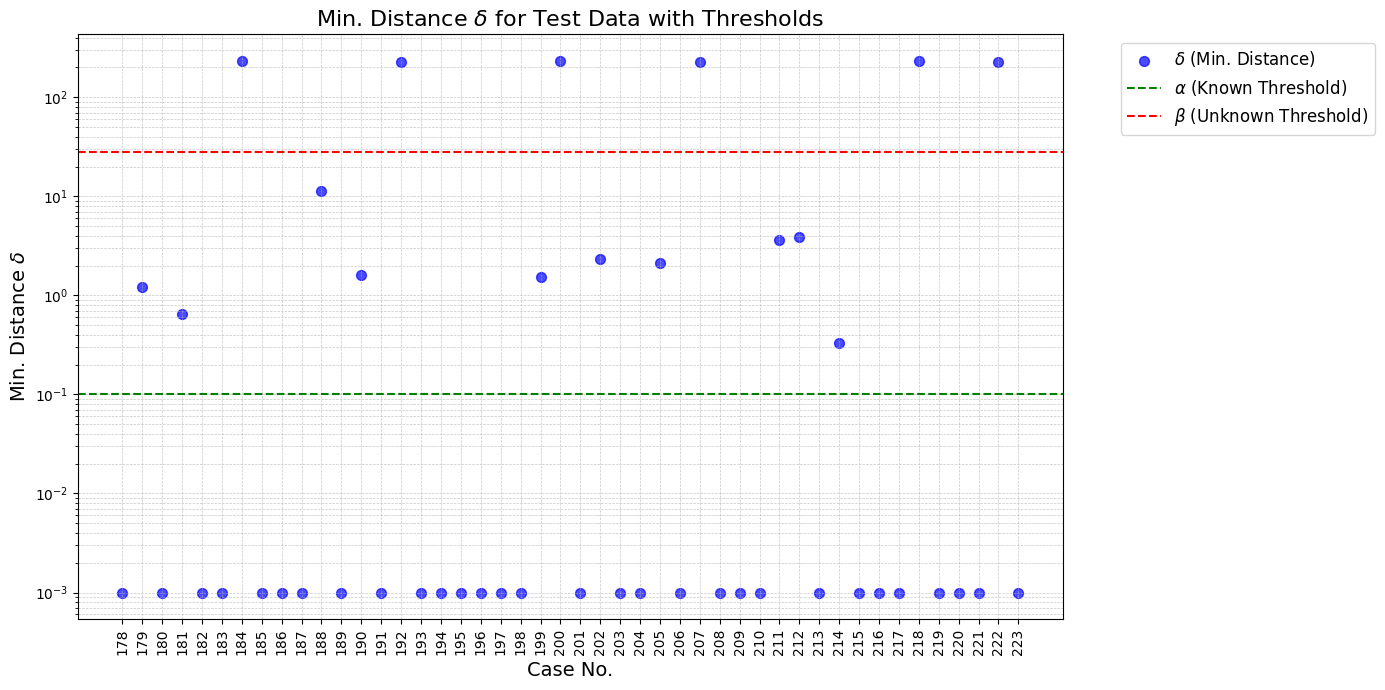

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Step 5: Generate the graph
# Extract minimum distances (DTW Distance) and corresponding test case numbers
test_case_numbers = results_df['Test Case'].str.extract(r'(\d+)').astype(int)[0].tolist()
min_distances = results_df['DTW Distance'].tolist()

# Apply the transformation for visualization (delta < 0.01 becomes 0.001)
adjusted_distances = [0.001 if d < 0.01 else d for d in min_distances]

# Plotting
plt.figure(figsize=(14, 7))
plt.scatter(test_case_numbers, adjusted_distances, label=r"$\delta$ (Min. Distance)", color="blue", s=50, alpha=0.7)
plt.axhline(y=alpha, color="green", linestyle="--", label=r"$\alpha$ (Known Threshold)")
plt.axhline(y=beta, color="red", linestyle="--", label=r"$\beta$ (Unknown Threshold)")

# Customize axes (log scale for y-axis)
plt.yscale("log")
plt.xlabel("Case No.", fontsize=14)
plt.ylabel("Min. Distance $\delta$", fontsize=14)
plt.title(r"Min. Distance $\delta$ for Test Data with Thresholds", fontsize=16)
plt.xticks(test_case_numbers, rotation=90, fontsize=10)

# Add legend with custom positioning
plt.legend(fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid and plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


Valve Opening Ratio and Fault Locations

In [ ]:
# Filter out test cases classified as "Solenoid Valve Fault"
solenoid_valve_fault_test_data = {
    result["Test Case"]: test_data[result["Test Case"]]
    for result in results
    if result["Classification"] == "Solenoid Valve Fault"
}

# Filter out training cases classified as "Fault" or "Normal" based on `labels_map`
solenoid_valve_fault_train_data = {
    key: train_data[key]
    for key in train_data
    if labels_map[int(key.replace("Case", ""))] == "Fault"
}

solenoid_normal_train_data = {
    key: train_data[key]
    for key in train_data
    if labels_map[int(key.replace("Case", ""))] == "Normal"
}

# Get the number of DataFrames in each dictionary
num_test_dataframes = len(solenoid_valve_fault_test_data)
num_train_fault_dataframes = len(solenoid_valve_fault_train_data)
num_train_normal_dataframes = len(solenoid_normal_train_data)

# Print results
print(f"Number of DataFrames in solenoid_valve_fault_test_data: {num_test_dataframes}")
print(f"Number of DataFrames in solenoid_normal_train_data: {num_train_normal_dataframes}")
print(f"Number of DataFrames in solenoid_valve_fault_train_data: {num_train_fault_dataframes}")


Number of DataFrames in solenoid_valve_fault_test_data: 10
Number of DataFrames in solenoid_normal_train_data: 105
Number of DataFrames in solenoid_valve_fault_train_data: 48


In [ ]:
import pandas as pd

def extract_pressure_drops(data, valve_opening_time):
    """
    Extracts pressure drops at a given time and just before that time for specified sensors.

    Parameters:
        data (dict): Dictionary of DataFrames keyed by case identifier.
        valve_opening_time (float): The exact time of the valve operation.

    Returns:
        pd.DataFrame: A DataFrame containing pressure drops for each case.
    """
    rows = []
    time_step = 0.010  # Time step before the valve operation to calculate the drop

    for key, df in data.items():
        # Ensure data is sorted by TIME to access by iloc
        df_sorted = df.sort_values('TIME')

        # Find indices nearest to the valve operation time and one step before
        idx_at = df_sorted['TIME'].sub(valve_opening_time).abs().idxmin()
        idx_before = df_sorted['TIME'].sub(valve_opening_time - time_step).abs().idxmin()

        # Calculate pressure drops for specified sensors
        row = {
            'Case': key,
            'delta_P3/sv1_valve_fault': df_sorted.at[idx_before, 'P3'] - df_sorted.at[idx_at, 'P3'],
            'delta_P4/sv2_valve_fault': df_sorted.at[idx_before, 'P4'] - df_sorted.at[idx_at, 'P4'],
            'delta_P6/sv3_valve_fault': df_sorted.at[idx_before, 'P6'] - df_sorted.at[idx_at, 'P6'],
            'delta_P7/sv4_valve_fault': df_sorted.at[idx_before, 'P7'] - df_sorted.at[idx_at, 'P7'],
        }
        rows.append(row)

    # Convert the list of rows into a DataFrame
    return pd.DataFrame(rows)

# Assuming valve_opening_time is known and the same across all datasets for simplicity
valve_opening_time = 0.012  # Example time, adjust based on actual data

# Extract pressure drops using the defined function
test_pressure_drops_df = extract_pressure_drops(solenoid_valve_fault_test_data, valve_opening_time)
train_pressure_drops_df = extract_pressure_drops(solenoid_valve_fault_train_data, valve_opening_time)
train_normal_pressure_drops_df = extract_pressure_drops(solenoid_normal_train_data, valve_opening_time)


In [ ]:
import pandas as pd

def calculate_average_normal_drops(train_data):
    """
    Calculate the average normal pressure drops from training data.

    Parameters:
        train_data (pd.DataFrame): DataFrame of training pressure drops.

    Returns:
        pd.Series: Average pressure drops for each sensor.
    """
    sensors = ['delta_P3/sv1_valve_fault', 'delta_P4/sv2_valve_fault', 'delta_P6/sv3_valve_fault', 'delta_P7/sv4_valve_fault']
    avg_drops = train_data[sensors].mean()
    return avg_drops

def identify_fault_location(test_data, normal_drops, specific_cases):
    """
    Identify the faulty sensor for each specific test case.

    Parameters:
        test_data (pd.DataFrame): DataFrame of test pressure drops.
        normal_drops (pd.Series): Average normal pressure drops for each sensor.
        specific_cases (list): List of specific test cases to process.

    Returns:
        pd.DataFrame: DataFrame with specific test cases and identified faulty sensors.
    """
    sensors = ['delta_P3/sv1_valve_fault', 'delta_P4/sv2_valve_fault', 'delta_P6/sv3_valve_fault', 'delta_P7/sv4_valve_fault']
    fault_locations = []

    # Filter test data to include only the specific cases
    filtered_test_data = test_data[test_data['Case'].isin(specific_cases)]

    for _, row in filtered_test_data.iterrows():
        differences = {sensor: normal_drops[sensor] - row[sensor] for sensor in sensors}
        fault_location = max(differences, key=differences.get)  # Sensor with the largest difference
        fault_locations.append({
            "Test Case": row['Case'],
            "Faulty Sensor": fault_location,
            "Difference": differences[fault_location]
        })

    # Convert to DataFrame and sort by Test Case in ascending order
    fault_locations_df = pd.DataFrame(fault_locations).sort_values(by="Test Case")
    return fault_locations_df

# Extract specific test cases from fault_locations_df
specific_test_cases = fault_locations_df['Test Case'].tolist()

# Calculate average normal drops from training data
normal_drops = calculate_average_normal_drops(train_normal_pressure_drops_df)
fault_drops = calculate_average_normal_drops(train_pressure_drops_df)

# Identify fault location for the extracted test cases
fault_locations_df = identify_fault_location(test_pressure_drops_df, normal_drops, specific_test_cases)

# Display the DataFrame with fault locations in ascending order
print("\nFault Locations DataFrame (Sorted):")
print(fault_locations_df.to_string(index=False))



Fault Locations DataFrame (Sorted):
Test Case            Faulty Sensor  Difference
  Case179 delta_P4/sv2_valve_fault    1.177230
  Case181 delta_P7/sv4_valve_fault    0.221164
  Case188 delta_P3/sv1_valve_fault    1.609877
  Case190 delta_P6/sv3_valve_fault    0.648846
  Case199 delta_P3/sv1_valve_fault    0.013452
  Case202 delta_P6/sv3_valve_fault    0.685644
  Case205 delta_P4/sv2_valve_fault    0.046689
  Case211 delta_P3/sv1_valve_fault    0.034578
  Case212 delta_P4/sv2_valve_fault    0.288877
  Case214 delta_P7/sv4_valve_fault    1.125968


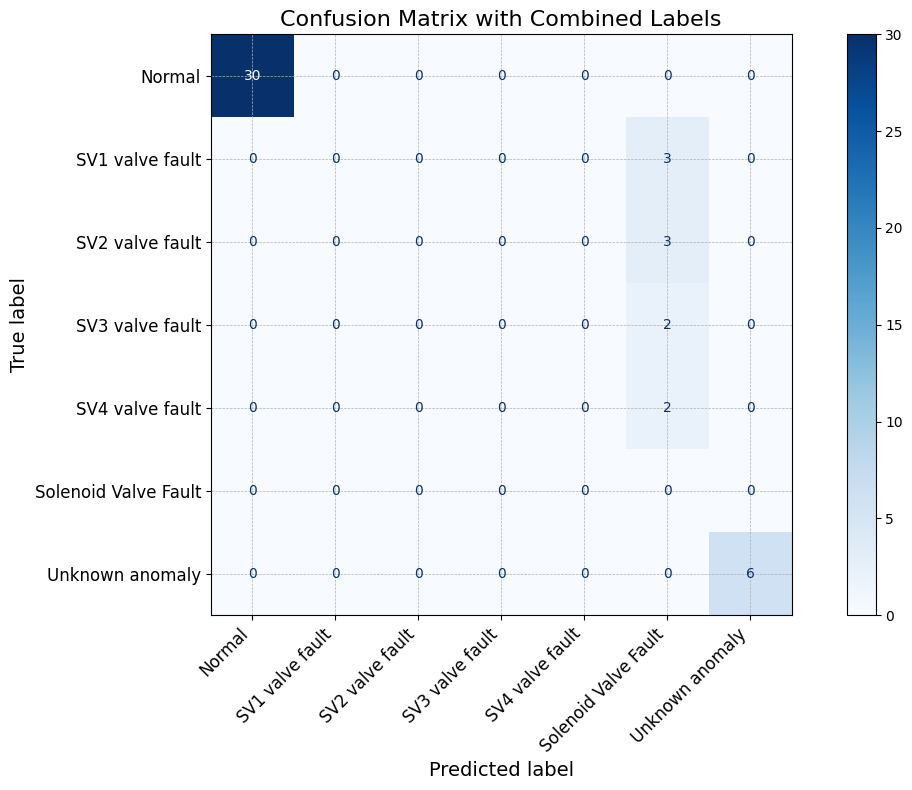

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# Step 1: Load training and test data
train_dir = '/content/drive/My Drive/Project 5/Project 5/Dataset/Train/data/'
test_dir = '/content/drive/My Drive/Project 5/Project 5/Dataset/Test/data/'
label_path = '/content/drive/My Drive/Project 5/Project 5/Dataset/Train/labels.xlsx'

# Load all training files into a dictionary
train_data = {}
for file in os.listdir(train_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(train_dir, file)
        df = pd.read_csv(file_path)
        train_data[file.replace('.csv', '')] = df

# Load all test files into a dictionary
test_data = {}
for file in os.listdir(test_dir):
    if file.endswith('.csv'):
        file_path = os.path.join(test_dir, file)
        df = pd.read_csv(file_path)
        test_data[file.replace('.csv', '')] = df

# Load labels from Excel
labels_df = pd.read_excel(label_path)
labels_df = labels_df.dropna(subset=['Case#', 'Condition']).copy()
labels_df['Case#'] = labels_df['Case#'].astype(int)
labels_map = dict(zip(labels_df['Case#'], labels_df['Condition']))

# Step 2: Load the true labels from the answer.csv file
answers_path = '/content/drive/My Drive/Project 5/Project 5/Dataset/Test/answer.csv'  # Replace with the correct path
answers_df = pd.read_csv(answers_path)

# Ensure the Case# column is consistent with your test case IDs
answers_df.rename(columns={"ID": "Case#"}, inplace=True)

# Simplify True Labels: Map BP# bubble anomaly to Normal
def simplify_true_label(label):
    if "bubble anomaly" in label:
        return "Normal"
    return label

answers_df["Simplified Test condition"] = answers_df["Test condition"].apply(simplify_true_label)

# Create a mapping of Case# to Simplified True Labels
true_labels_map = dict(zip(answers_df['Case#'], answers_df['Simplified Test condition']))

# Step 3: Extract Predicted Labels
# Use the `results_df` DataFrame from previous steps
detailed_predicted_labels = results_df["Classification"].tolist()

# Extract true labels from simplified mapping using the results_df Test Cases
true_labels = []
for case_number in results_df["Test Case"]:
    case_id = int(case_number.replace("Case", ""))  # Convert to integer for mapping
    true_label = true_labels_map.get(case_id, "Unknown anomaly")  # Default to Unknown anomaly if missing
    true_labels.append(true_label)

# Remap true and predicted labels for combined categories
label_mapping = {
    "Unknown": "Unknown anomaly",
    "Known": "Normal",
    "Normal": "Normal",
    "Unknown anomaly": "Unknown anomaly",
    "Solenoid Valve Fault": "Solenoid Valve Fault",
    "SV1 valve fault": "SV1 valve fault",
    "SV2 valve fault": "SV2 valve fault",
    "SV3 valve fault": "SV3 valve fault",
    "SV4 valve fault": "SV4 valve fault",
}

# Apply mapping to true and predicted labels
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in detailed_predicted_labels]

# Get unique labels after remapping
all_labels_combined = sorted(set(mapped_true_labels).union(set(mapped_predicted_labels)))

# Step 4: Generate Confusion Matrix
conf_matrix_combined = confusion_matrix(
    mapped_true_labels,
    mapped_predicted_labels,
    labels=all_labels_combined  # Use combined labels
)

# Display updated confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))  # Larger figure for better visibility

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_combined, display_labels=all_labels_combined)
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

# Update plot for clarity
plt.title("Confusion Matrix with Combined Labels", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.xticks(fontsize=12, rotation=45, ha='right')  # Rotate labels for better spacing
plt.yticks(fontsize=12)
plt.grid(visible=True, which="major", linestyle="--", linewidth=0.5)
plt.tight_layout()

# Show the plot
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Labels DataFrame Columns: Index(['Case#', 'Spacecraft#', 'Condition', 'SV1', 'SV2', 'SV3', 'SV4', 'BP1',
       'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'BV1'],
      dtype='object')
Filtered Pressure Drops: [1.784500855, 1.868990175, 1.868990175, 1.8628265370000001, 1.7845008545827228, 1.8689901749678353, 1.8689901749678388, 1.8628265369810755, 1.7845008545827228, 1.8689901749678353, 1.8689901749678388, 1.8628265369810755, 1.7845008545827228, 1.8689901749678353, 1.8689901749678388, 1.8628265369810755, 1.7845008545827228, 1.8689901749678353, 1.8689901749678388, 1.8628265369810755, 1.7845008545827228, 1.8689901749678353, 1.8689901749678388, 1.8628265369810755, 1.7845008545827228, 1.8689901749678353, 1.8689901749678388, 1.8628265369810755, 1.7845008545827228, 1.8689901749678353, 1.8689901749678388, 1.8628265369810755, 1.7845008545827228, 1.8689901749678353, 1.

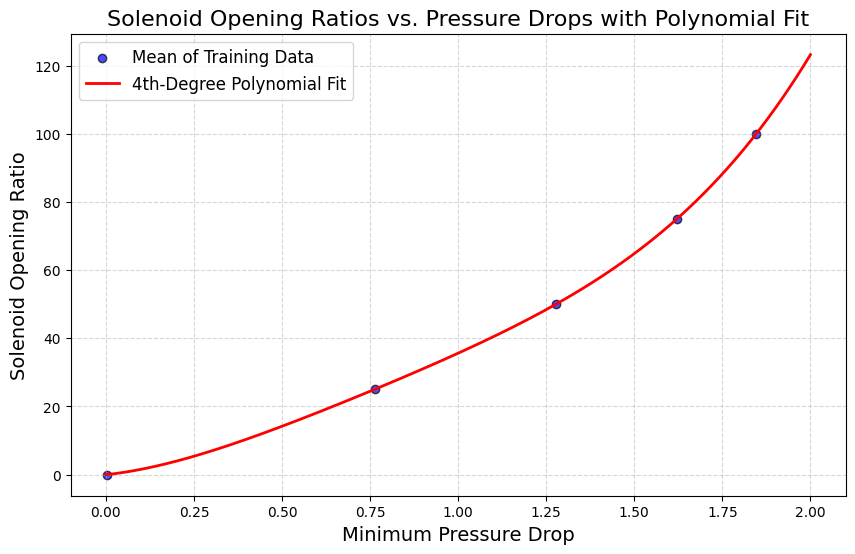

[ 1.39028959e+01 -4.10009461e+01  5.16300316e+01  1.11155994e+01
 -2.86120445e-02]
Columns in file Case205.csv: ['TIME', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
Test case Case205.csv: Solenoid SV1, Min Pressure Drop: 1.7845008904423127, Estimated Ratio: 92.21121295006839%
Columns in file Case179.csv: ['TIME', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
Test case Case179.csv: Solenoid SV2, Min Pressure Drop: 0.6917600875388197, Estimated Ratio: 21.978486964512612%
Columns in file Case190.csv: ['TIME', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
Test case Case190.csv: Solenoid SV3, Min Pressure Drop: 1.2201436921615478, Estimated Ratio: 46.73454114529692%
Columns in file Case211.csv: ['TIME', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
Test case Case211.csv: Solenoid SV1, Min Pressure Drop: 1.7499230364875638, Estimated Ratio: 88.18646052338215%
Columns in file Case199.csv: ['TIME', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7']
Test case Case199.csv: Solenoid SV1, Min Pressure Drop: 1.7710492679

In [ ]:
import os
import pandas as pd
import numpy as np

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')


# Path to the labels file
labels_path = '/content/drive/My Drive/Project 5/Project 5/Dataset/Train/labels2.xlsx'
labels_df = pd.read_excel(labels_path)

# Directory containing the training data CSV files
train_dir = '/content/drive/My Drive/Project 5/Project 5/Dataset/Train/data'


THRESHOLD = 1e-10

sensor_mapping = {
    'SV1': 'P3',
    'SV2': 'P4',
    'SV3': 'P6',
    'SV4': 'P7'
}


def calculate_pressure_drop(pressure_data, threshold):
    """
    Calculate the first significant pressure drop above the threshold.

    Parameters:
        pressure_data (numpy array): Array of pressure values.
        threshold (float): Minimum allowable pressure drop.

    Returns:
        float: First significant pressure drop.
    """
    for i in range(1, len(pressure_data)):
        drop = pressure_data[0] - pressure_data[i]
        if drop > threshold:
            return drop
    return 0.0  # Return 0 if no drop exceeds the threshold

# Read labels file and verify column names
labels_df = pd.read_excel(labels_path)
print("Labels DataFrame Columns:", labels_df.columns)

# Ensure the 'Case#' column exists and adjust the case id format if necessary
case_column = 'Case#'  # This is the column for case numbers
if case_column not in labels_df.columns:
    raise ValueError(f"Column '{case_column}' not found in labels file. Check the file and update the column name.")

# Prepare arrays for pressure drops and solenoid ratios
pressure_drops_array = []
solenoid_ratios_array = []

# Process each CSV file in the training directory
for file_name in sorted(os.listdir(train_dir)):
    if file_name.endswith('.csv'):
        # Read the pressure data
        file_path = os.path.join(train_dir, file_name)
        pressure_df = pd.read_csv(file_path)

        # Extract the case number (e.g., Case001)
        case_id = file_name.split('.')[0]

        # Retrieve the corresponding solenoid open ratios
        case_labels = labels_df[labels_df[case_column] == int(case_id.replace('Case', ''))]

        # Skip if no labels are found for this case
        if case_labels.empty:
            print(f"Warning: No labels found for {case_id}. Skipping this file.")
            continue

        # Iterate through solenoid-pressure mappings
        for solenoid, pressure_col in sensor_mapping.items():
            if pressure_col in pressure_df.columns:
                # Calculate pressure drop
                pressure_data = pressure_df[pressure_col].to_numpy()
                pressure_drop = calculate_pressure_drop(pressure_data, THRESHOLD)

                # Get the corresponding solenoid open ratio
                solenoid_ratio = case_labels[solenoid].values[0]

                # Append results
                pressure_drops_array.append(pressure_drop)
                solenoid_ratios_array.append(solenoid_ratio)

# Convert results to numpy arrays for further analysis
pressure_drops_array = np.array(pressure_drops_array)
solenoid_ratios_array = np.array(solenoid_ratios_array)

# Exclude cases where the pressure drop is less than 1 and the solenoid open ratio is 100%
filtered_pressure_drops = []
filtered_solenoid_ratios = []

for i, drop in enumerate(pressure_drops_array):
    # Only include the data point if the pressure drop is >= 1, or the solenoid ratio is not 100%
    if drop >= 1 or solenoid_ratios_array[i] != 100:
        filtered_pressure_drops.append(drop)
        filtered_solenoid_ratios.append(solenoid_ratios_array[i])

# Print the filtered arrays for debugging
print("Filtered Pressure Drops:", filtered_pressure_drops)
print("Filtered Solenoid Ratios:", filtered_solenoid_ratios)

# You can now proceed with further analysis or fitting using these filtered arrays
# Create a DataFrame with solenoid ratios and pressure drops
data = {'solenoid_ratio': filtered_solenoid_ratios, 'pressure_drop': filtered_pressure_drops}
df = pd.DataFrame(data)

# Group by solenoid ratio and calculate the average pressure drop for each ratio
average_pressure_drops = df.groupby('solenoid_ratio')['pressure_drop'].mean().reset_index()

# Print the results
print(average_pressure_drops)
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

# Fit a 4th-degree polynomial
coefficients = np.polyfit(average_pressure_drops['pressure_drop'], average_pressure_drops['solenoid_ratio'], deg=4)

# Generate the polynomial function
polynomial = np.poly1d(coefficients)

# Create a range of pressure drops for plotting the polynomial fit
pressure_drop_range = np.linspace(0, 2, 500)

# Evaluate the polynomial for the pressure drop range
fitted_ratios = polynomial(pressure_drop_range)

# Plot the original data and the polynomial fit
plt.figure(figsize=(10, 6))

# Scatter plot of original data
plt.scatter(average_pressure_drops['pressure_drop'], average_pressure_drops['solenoid_ratio'], color='blue', alpha=0.7, edgecolor='k', label='Mean of Training Data')

# Plot the polynomial fit
plt.plot(pressure_drop_range, fitted_ratios, color='red', linewidth=2, label='4th-Degree Polynomial Fit')

# Adding titles and labels
plt.title('Solenoid Opening Ratios vs. Pressure Drops with Polynomial Fit', fontsize=16)
plt.xlabel('Minimum Pressure Drop', fontsize=14)
plt.ylabel('Solenoid Opening Ratio', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Display the plot
plt.show()

THRESHOLD = 1e-10

sensor_mapping = {
    'SV1': 'P3',
    'SV2': 'P4',
    'SV3': 'P6',
    'SV4': 'P7'
}
print(coefficients)

# Path to the test directory
test_dir = '/content/drive/My Drive/Project 5/Project 5/Dataset/Test/data'

# Read test data
test_files = [f for f in os.listdir(test_dir) if f.endswith('.csv')]

def polynomial_fit(x, coeffs):
    """
    Evaluate the polynomial given the input x (pressure drop) and the coefficients in correct order (highest exponent first).
    """
    return sum(c * x**(len(coeffs)-1-i) for i, c in enumerate(coeffs))


# Initialize lists to store results
predicted_ratios = []
min_pressure_drops = []

# Loop through each test file
for file in test_files:
    # Extract the case number from the file name (e.g., "Case179")
    case_id = file.split('.')[0]

    # Check if the current test case is in the specific test cases
    if case_id not in specific_test_cases:
        continue  # Skip this test file if it's not in the list

    # Load test case data
    test_data = pd.read_csv(os.path.join(test_dir, file))

    # Print out the column names to debug
    print(f"Columns in file {file}: {test_data.columns.tolist()}")

    # Assuming the columns are 'Time', 'P3', 'P4', 'P6', 'P7' corresponding to the pressure measurements
    if 'Time' in test_data.columns:
        time_series = test_data['Time'].values
    else:
        time_series = np.arange(len(test_data))  # If no Time column, use the index as time

    pressures = test_data[['P3', 'P4', 'P6', 'P7']].iloc[0].values  # Use the first row for the case

    # Calculate the pressure drop for each solenoid
    pressure_drops = []
    for sensor in ['P3', 'P4', 'P6', 'P7']:
        initial_pressure = 2  # The initial pressure (start value, as defined)
        pressure_series = test_data[sensor].values

        # Find the first value after the initial pressure drop that is above a threshold
        drop_indices = np.where(pressure_series < initial_pressure - 1e-10)[0]
        if drop_indices.size > 0:
            pressure_drop = initial_pressure - pressure_series[drop_indices[0]]
        else:
            pressure_drop = 0  # If no drop occurs, set drop to 0

        pressure_drops.append(pressure_drop)

    # Identify the solenoid with the minimum pressure drop
    min_pressure_drop = min(pressure_drops)
    min_pressure_drop_index = np.argmin(pressure_drops)

    # Get the associated solenoid based on the minimum pressure drop
    solenoid = list(sensor_mapping.keys())[min_pressure_drop_index]

    # Estimate the open ratio using the polynomial fit for the identified solenoid
    estimated_ratio = polynomial_fit(min_pressure_drop, coefficients)

    # Add results to lists
    predicted_ratios.append(estimated_ratio)
    min_pressure_drops.append(min_pressure_drop)

    # Print result for debugging
    print(f"Test case {file}: Solenoid {solenoid}, Min Pressure Drop: {min_pressure_drop}, Estimated Ratio: {estimated_ratio}%")

<ipython-input-15-bb6cf4855c93>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_cases))  # Use a colormap for different colors


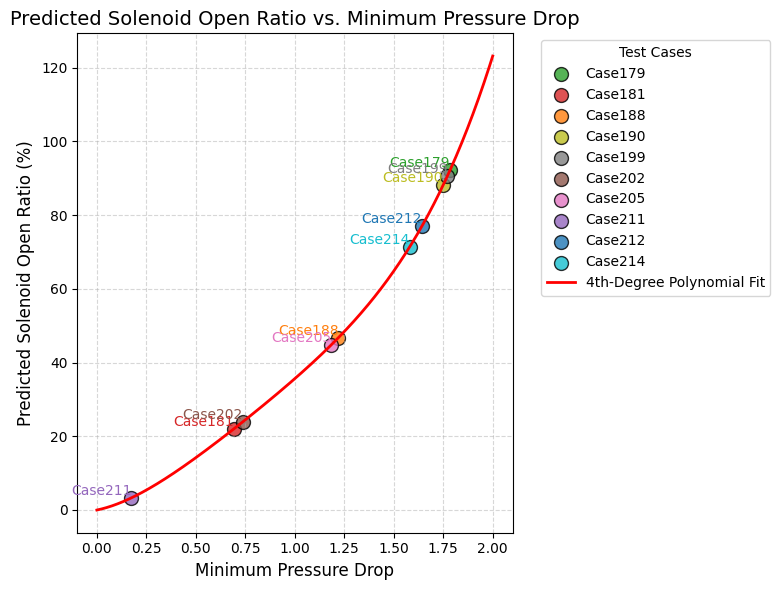

In [ ]:
# Define colors for each test case
unique_cases = set(specific_test_cases)
colors = plt.cm.get_cmap('tab10', len(unique_cases))  # Use a colormap for different colors

# Initialize lists to store results for plotting
case_colors = {case: colors(i) for i, case in enumerate(unique_cases)}

plt.figure(figsize=(10, 6))

# Scatter plot with annotations for test cases
for i, (drop, ratio, case) in enumerate(zip(min_pressure_drops, predicted_ratios, specific_test_cases)):
    color = case_colors[case]  # Assign a unique color to each test case
    plt.scatter(drop, ratio, color=color, label=case, alpha=0.8, edgecolor='k', s=100)
    plt.text(drop, ratio, case, fontsize=10, ha='right', va='bottom', color=color)  # Annotate the plot

# Plot the polynomial fit
plt.plot(pressure_drop_range, fitted_ratios, color='red', linewidth=2, label='4th-Degree Polynomial Fit')

# Adding titles and labels
plt.title('Predicted Solenoid Open Ratio vs. Minimum Pressure Drop', fontsize=14)
plt.xlabel('Minimum Pressure Drop', fontsize=12)
plt.ylabel('Predicted Solenoid Open Ratio (%)', fontsize=12)

# Enhance grid and legend
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1), title='Test Cases')
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust layout to fit the legend

# Display the plot
plt.show()